In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

# Modelo: Naive Bayes

https://scikit-learn.org/stable/modules/naive_bayes.html

Laburaremos con el modelo de **Naive Bayes**, se conocen 3 diferentes formas de implementar: 
* Cuando trabajamos con features continuos -> (GaussianNB)
* Cuando trabajamos con features discretos -> (MultinomialNB)
* Cuando trabajamos con features categoricos -> (CategoricalNB)

Estaremos utilizando los 3 tipos de tecnicas de Naive Bayes. Esto implica tener que dividir nuestro dataset de 3 formas distintas.

Importamos diferentes funciones del preprocessing.py que utilizaremos:

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion

# GaussianNB

In [3]:
from sklearn.naive_bayes import GaussianNB

Solo para valores continuos. Es decir nos quedaremos con las 2 columnas numéricas continuas de 'edad' y 'suma_declarada_bolsa_argentina'

In [4]:
df, df_for_prediction = obtener_datasets()
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456,0.240810
std,2.664488,13.640433,7408.986951,12.347429,0.427581
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,37.000000,0.000000,40.000000,0.000000
75%,16.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


## Primer Preprocesamiento: obtener_features_continuas()

Empezamos primero importando la función creada en el preprocessing.py que nos da el dataset con las features continuas mencionadas

In [5]:
from preprocessing import obtener_features_continuas

Ademas aplicamos la preparación al dataset que ya venimos comentando en otros notebooks y luego aplicamos esta funcion importada para obtener las features consideradas como variables continuas.

In [6]:
df, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df_c = obtener_features_continuas(X_df) 

Entre hiperparametros improtantes está el 'var_smoothing' es aquel factor que se le asigna cuando viene eventos con probabilidades igual a 0 de elementos que nunca vió. Este hiperparametro es el unico que se tendrá en cuenta al utilizar GridSearchCV. Recordemos tambien que inicialmente haremos una particion del dataset de manera straficada, además al utilizar cross-validation con GridSearch le estaremos indicando que haga folds stratificados con StatifiedKFold manteniendo las diferentes proporciones de la clase a predecir en cada fold.

Entrenemos con todo lo mencionado:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_df_c, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.2s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f2134434740>,
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09,
                                           1e-08, 1e-07]},
             scoring='roc_auc', verbose=4)

Vamos a predecir ahora con X_test y mostrar diferentes métricas:

AUC-ROC score sobre test:  0.7608417722498504
AUC-ROC score sobre train:  0.7643356120777687
Accuracy sobre test:  0.7930293259634577
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.98      0.80      0.88      6061
  Alto valor       0.21      0.74      0.33       452

    accuracy                           0.79      6513
   macro avg       0.60      0.77      0.61      6513
weighted avg       0.92      0.79      0.84      6513



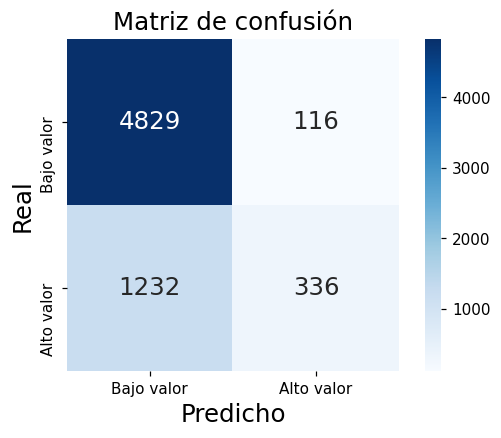

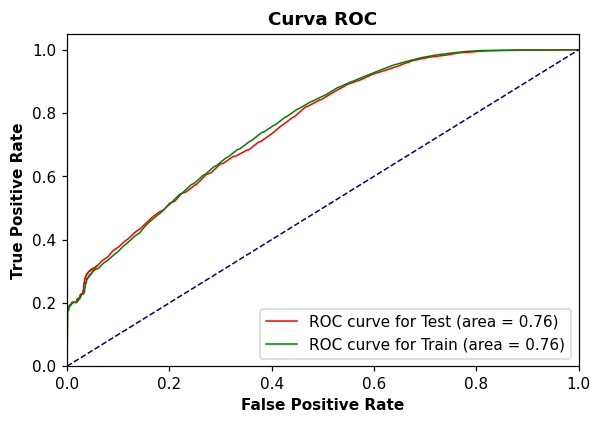

In [8]:
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)

Lo cual se puede observar que a pesar de haber solo utilizado 2 features, no fue un muy mal resultado. Es mucho mejor que un modelo random.

Guardamos la prediccion de probabilidad de cada clase para usarlo en un futuro ensamble gaussiano. Por ahora nos quedamos como mejor preprocesamiento a éste ultimo aplicado.

In [9]:
proba_gauss_train = clf.predict_proba(X_train)
proba_gauss_test = clf.predict_proba(X_test)

## Segundo Preprocesamiento: get_dataframe_scaled()

En este segundo preprocesamietno, utilizaremos 5 escalados guardados en un vector al cual aplicaremos con nuestra función get_dataframe_scaled(). Es decir GaussianNB entrenará 5 preprocesamietnos distintos, uno por uno. Importamos nuestra funcion y los 5 escalados:


In [10]:
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    Normalizer
)

Entrenemos entonces el modelo con estos 5 preprocesamientos (escalados).

In [11]:
X_df_c = obtener_features_continuas(X_df) 
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), Normalizer()]
for count, scaler in enumerate(scalers):
    print("---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
    df_scaled = get_dataframe_scaled(X_df_c, scaler)
    X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_df, test_size=0.20, random_state=10, stratify=y_df)        
    params =  {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}

    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)  

---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de StandardScaler()
 AUC-ROC score sobre test:  0.7608415787953200
AUC-ROC score sobre train:  0.7643349026782453
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.7608413853407895
AUC-ROC score sobre train:  0.7643346366534238
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con scaler de RobustScaler()
 AUC-ROC score sobre test:  0.7608417722498504
AUC-ROC score sobre train:  0.7643356120777687
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con scaler de PowerTransformer()
 AUC-R

Se pudo observar que el escalado "PowerTransformer()" es superior al resto en cuanto el AUC-ROC ya demás superó al primer preprocesamiento realizado.

## Eligiendo al mejor: get_dataframe_scaled(PowerTransformer())

Repliquemos la situación ya con el mejor hiperparametro encontrado con este escalado:

    Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13} con el preprocesameinto PowerTransformer()

In [12]:
X_df_c = obtener_features_continuas(X_df) 
df_scaled = get_dataframe_scaled(X_df_c, PowerTransformer())

X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_df, test_size=0.20, random_state=10, stratify=y_df)        

clf = GaussianNB(var_smoothing=1e-13)
        
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))


 AUC-ROC score sobre test:  0.7660732341470461
AUC-ROC score sobre train:  0.7672718046136364
Accuracy sobre test:  0.7882696146169200


Veamos la matriz de confusión y diferentes métricas:


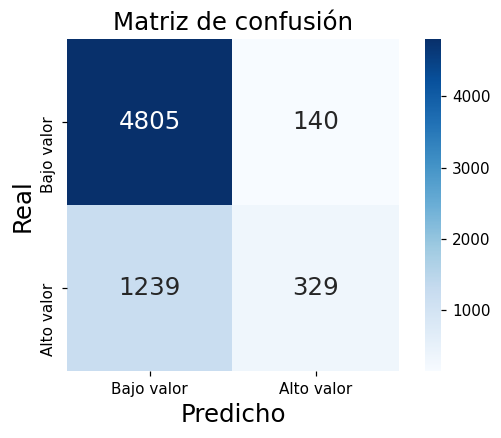

In [13]:
graficar_matriz_confusion(y_test, y_pred)

In [14]:
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))

              precision    recall  f1-score   support

  Bajo valor       0.97      0.80      0.87      6044
  Alto valor       0.21      0.70      0.32       469

    accuracy                           0.79      6513
   macro avg       0.59      0.75      0.60      6513
weighted avg       0.92      0.79      0.83      6513



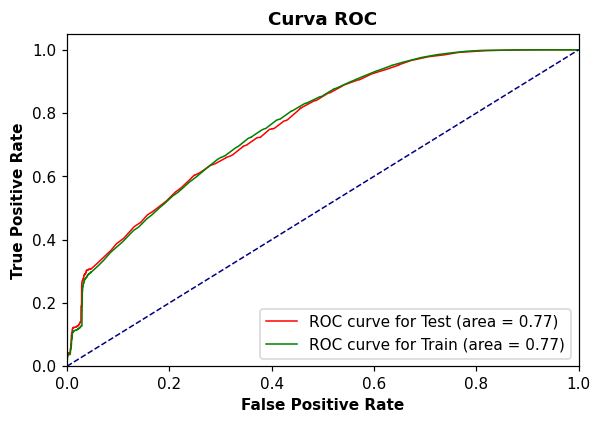

In [15]:
plot_roc_curves(clf, X_test, y_test, X_train, y_train)

Vemos que tiene graves problemas la precisión de los altos valores como nos suele ocurrir con los diferentes modelos probados. Aún así nos quedaremos con éste como "mejor modelo" para utilizarlo despues en un futuro ensamble:

In [16]:
proba_gauss_train = clf.predict_proba(X_train)
proba_gauss_test = clf.predict_proba(X_test)

# MultinomialNB

Solo para valores discretos.

## Primer Preprocesamiento: obtener_features_discretas()

Algo similar como hicimos en el TP1 al discretizar la edad: importaremos nuestra función que discretizará todas nuestras features. A las categoricas las convierte a binarias tal como venia haciendo la "conversion_numerica" que veniamos laburando en otros notebooks, pero en adicion a esto, la función de "obtener_features_discretas" también discretiza la "suma_declarada_bolsa_argentina" con valores entre 0 a 8. Además de forma similar ocurrirá con las horas de trabajo registradas y la edad alcanzada. Es decir, dejamos como discreta-pura a la de anios estudiados sin ser alterada.

Consideramos a esto mencionado como el *primer preprocesamiento* a aplicar:

In [17]:
from preprocessing import obtener_features_discretas
X_df_d_n = obtener_features_discretas(X_df)
X_df_d_n.describe()

Aplicando 'conversion_numerica' en las variables categóricas.


,edad,anios_estudiados,educacion_alcanzada,suma_declarada_bolsa_argentina,horas_trabajo_registradas,genero_mujer,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado_a,...,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,2.494641,14.053868,4.204539,0.124597,2.035748,0.330795,0.459937,0.000706,0.012837,0.031479,...,0.000215,0.000430,0.031909,0.854274,0.095943,0.008323,0.155646,0.030128,0.255060,0.105832
std,1.925783,2.664488,0.956610,0.613312,0.821068,0.470506,0.498400,0.026569,0.112575,0.174612,...,0.014661,0.020731,0.175761,0.352837,0.294518,0.090851,0.362525,0.170942,0.435901,0.307627
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,13.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,14.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,16.000000,5.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,9.000000,20.000000,6.000000,7.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dividiamos como veniamos haciendo con el GaussianNB recordando que es de manera estratificada tanto en el train_test_split y en GridSearchCV con StratifiedKFold.

Lo que tenemos en cuenta ahora con GridSearchCV es el hiperparametro de 'alpha' que actúa de forma similar al 'var_smoothing' (es decir,evitar eventos con probabilidad nulas) pero segun entendemos en la biblografia (https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) lo podemos ir probando 0 y 1. 

Entrenemos entonces:

In [18]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X_df_d_n, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}

clf = MultinomialNB()
cv = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.7s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f2100be3890>,
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1]},
             scoring='roc_auc', verbose=4)

Veamos diferentes métricas y gráficos:

AUC-ROC score sobre test:  0.8650272255009184
AUC-ROC score sobre train:  0.8678716381868958
Accuracy sobre test:  0.7990173499155535
Los mejores hiperpametros elegidos:  {'alpha': 0.3}
              precision    recall  f1-score   support

  Bajo valor       0.83      0.90      0.86      4602
  Alto valor       0.69      0.57      0.62      1911

    accuracy                           0.80      6513
   macro avg       0.76      0.73      0.74      6513
weighted avg       0.79      0.80      0.79      6513



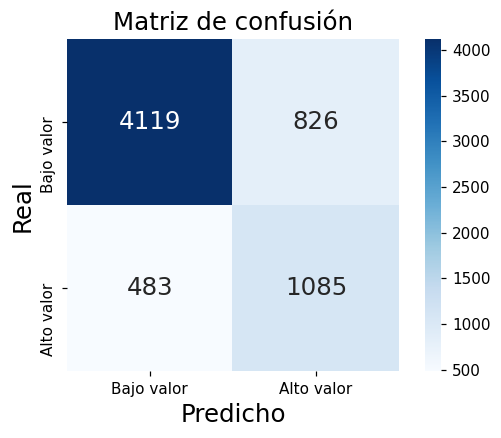

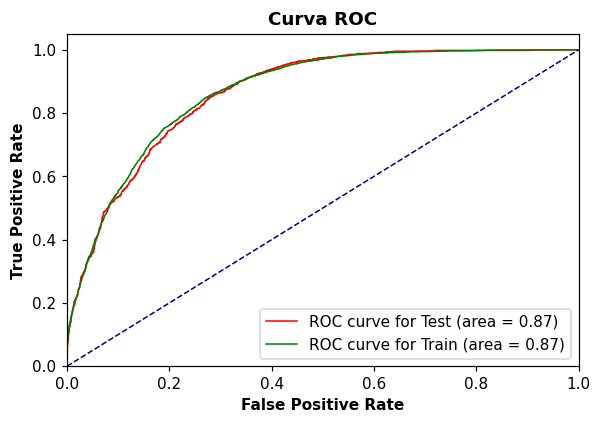

In [19]:
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


La verdad, un buen modelo en general con tan solo ver la diagonal de la matriz de confusión. El AUC-ROC también se ve una buena mejora en comparación al modelo GaussianoNB.
Mantendremos a este como el mejor modelo para un futuro ensamble gaussiano:

In [20]:
proba_multi_train = clf.predict_proba(X_train)
proba_multi_test = clf.predict_proba(X_test)

Probemos un segundo preprocesamiento:

## Segundo Preprocesamiento: Scalers

En este segundo preprocesamiento probaremos solamente 2 escalados: MinMaxScaler() y Normalizer() con nuestra función get_dataframe_scaled(), pues los demás preprocesamientos nos dan valores negativos y MultinomialNB solo trata con valores discretos mayores a cero. Veamos si esto mejora un poco el anterior resultado.

In [21]:
scalers = [MinMaxScaler(), Normalizer()]
X_df_d = obtener_features_discretas(X_df)

for count, scaler in enumerate(scalers):
    print("---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con scaler de", scaler)
    df_scaled = get_dataframe_scaled(X_df_d, scaler)
    X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_df, test_size=0.20, random_state=10, stratify=y_df)        
    
    params = {
            'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
    }
    cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
    clf = GridSearchCV(MultinomialNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
    print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Aplicando 'conversion_numerica' en las variables categóricas.
---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con scaler de MinMaxScaler()
 AUC-ROC score sobre test:  0.8563973478673572
AUC-ROC score sobre train:  0.8596401611223669
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con scaler de Normalizer()
 AUC-ROC score sobre test:  0.8545626251005963
AUC-ROC score sobre train:  0.8590594611828472
Los mejores hiperpametros elegidos:  {'alpha': 0.001}


Empeoró rotundamente ambos preprocesamiento con escalados la métrica de AUC-ROC sobre test.
Nos quedaremos entonces con el primer preprocesamiento simple.

# CategorialNB

## Primer Preprocesameitno: conversion_numerica()

Este metodo de NB considera solo las variables categoricas, nosotros teniamos 

In [22]:
len(df.columns) - len(df.describe().columns)

7

Un total de 7 variables categoricas. Según la biblografía (https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes) recomienda que el frame **X** que usaremos para entrenar esté encodeado. Seguiremos manteniendo la escencia de convertir a binaria aquellas variables categoricas que no representan un valor de orden, y luego con orden a las que sí (la educación alcanzada por ejemplo).

In [23]:
X_df_cat = conversion_numerica(X_df[['categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])
X_df_cat.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 36)

Quedandonos así 36 features encodeadas, provenientes de variables categóricas. Apliquemos otra vez como venimos haciendo la division en train y test, luego GridSearchCV con StratifiedKFold y entrenemos.

Tanto CategorialNB como MultinomialNB consideraremos como hiperparaemtro importante al mismo 'alpha'

In [24]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}

clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    2.4s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f2100cd6dd0>,
             estimator=CategoricalNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1]},
             scoring='roc_auc', verbose=4)

Vamos a predecir y mostrar algunas métricas:

AUC-ROC score sobre test:  0.8602924903530673
AUC-ROC score sobre train:  0.8630706398682936
Accuracy sobre test:  0.7813603562106556
Los mejores hiperpametros elegidos:  {'alpha': 0.1}
              precision    recall  f1-score   support

  Bajo valor       0.79      0.91      0.85      4307
  Alto valor       0.75      0.53      0.62      2206

    accuracy                           0.78      6513
   macro avg       0.77      0.72      0.73      6513
weighted avg       0.78      0.78      0.77      6513



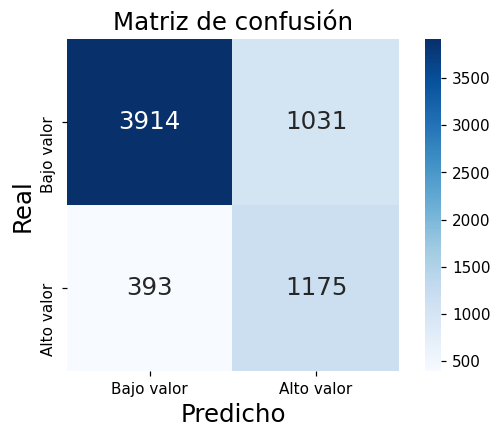

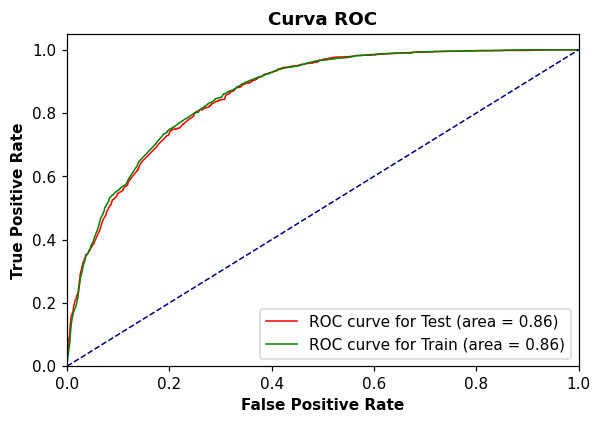

In [25]:
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)

Un modelo bastante bueno otra vez con buen AUC-ROC aunque empeoró la precision de los de bajo valor

Guardemos entonces las probabilidades de este modelo como las mejores por ahora:

In [26]:
proba_catego_train = clf.predict_proba(X_train)
proba_catego_test = clf.predict_proba(X_test)

## Segundo Preprocesamietno: conversion_numerica_generalizada()

Aplicaremos un segundo preprocesamiento donde se incluye una generalización de features, agregando la categoria de barrios indicando si se pertenece a palermo o no, como tambien ahora la educacion alcanzada se vuelve mas general tomando cada nivel alcanzado. Importemos y apliquemos entonces esta función:

In [27]:
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada

In [28]:
df_, df_for_prediction = obtener_datasets()
X_df, y_df = aplicar_preparacion_generalizado(df_)

In [29]:
X_df_cat = conversion_numerica_generalizada(X_df[['barrio','categoria_de_trabajo', 'educacion_alcanzada', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']])
X_df_cat.shape

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


(32561, 39)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    4.7s finished


AUC-ROC score sobre test:  0.8628155243391593
AUC-ROC score sobre train:  0.8653079771371819
Accuracy sobre test:  0.7799785045294028
Los mejores hiperpametros elegidos:  {'alpha': 0.001}
              precision    recall  f1-score   support

  Bajo valor       0.79      0.91      0.85      4308
  Alto valor       0.75      0.53      0.62      2205

    accuracy                           0.78      6513
   macro avg       0.77      0.72      0.73      6513
weighted avg       0.78      0.78      0.77      6513



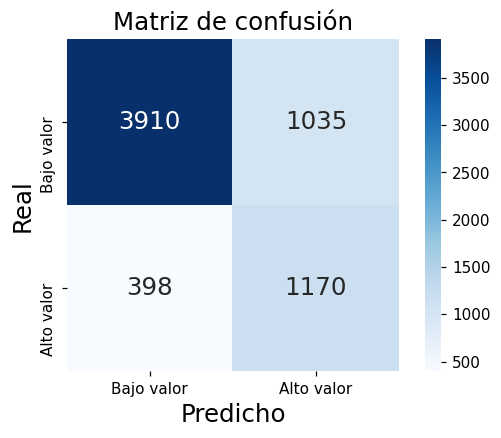

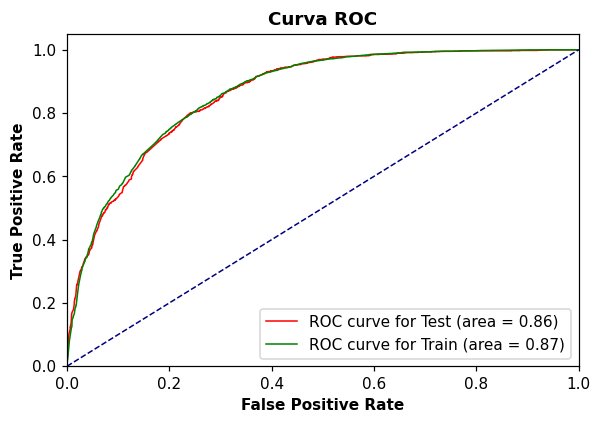

In [30]:
from sklearn.naive_bayes import CategoricalNB

X_train, X_test, y_train, y_test = train_test_split(X_df_cat, y_df, test_size=0.20, random_state=10, stratify=y_df)

params = {
        'alpha': [0.0001, 0.001, 0.1, 0.3, 0.6, 0.9, 1],
}


clf = CategoricalNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Vemos una mejora respecto al AUC-ROC anterior. Nos quedaremos entonces este como mejor modelo para usar en el ensamble.

## Eligiendo al mejor: conversion_numerica_generalizada()

In [31]:
proba_catego_train = clf.predict_proba(X_train)
proba_catego_test = clf.predict_proba(X_test)

# Aplicando ensamble Gaussiano

Teniendo en cuenta lo visto en la clase práctica de la materia:

    "en sklearn no tiene la funcionalidad de trabajar al mismo tiempo con variables categoricas y variables continuas. Se podria hacer un ensamble agarramos las probabilidades de GaussianNB, MultinomialNB y CategoricalNB y le metemos un gaussianNB al final juntando lo que devuelven los anteriores"


Nos guiaremos ademas en la idea de utiliza las funciones de np.hstack tal como lo mencionado en la siguiente fuente:

https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [32]:
X_train_assemble = np.hstack((proba_gauss_train, proba_multi_train, proba_catego_train))
X_test_assemble = np.hstack((proba_gauss_test, proba_multi_test, proba_catego_test))

Podriamos intentar unir este *X_train* y *X_test* de la sigueinte forma: 

X_df_new = pd.DataFrame(np.vstack((X_train_assemble, X_test_assemble)))

Para despues agarrar train_test_split() y dividir (otra vez) en train y test.

Pero no seria lo correcto por que estamos **asumiendo** que la division realizada por **train_test_split()** haya sido **consecutiva**.

In [33]:
X_train_assemble.shape

(26048, 6)

In [34]:
X_test_assemble.shape

(6513, 6)

Es decir, asumiriamos que agarró los 26048 elementos primero, y luego 6513 siguientes: eso no realiza *train_test_split* pues, la misma lo dividide teniendo en cuenta un factor random (lo cual al indicar el random_state=10 mantenemos siempre el mismo split) y ademas tiene en cuenta la division con respecto a la proporcion de la clase (stratify) a predecir como veniamos aplicando en diferentes splits.

Al aplicar ese *np.vstack* asumimos que esto no haya pasado y por consiguiente el modelo nos podria dar cualquier cosa.

Comprobemoslo:

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.1s finished
/home/feduntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC-ROC score sobre test:  0.4885585187057634
AUC-ROC score sobre train:  0.5067140150541833
Accuracy sobre test:  0.7592507293106096
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       1.00      0.76      0.86      6513
  Alto valor       0.00      0.00      0.00         0

    accuracy                           0.76      6513
   macro avg       0.50      0.38      0.43      6513
weighted avg       1.00      0.76      0.86      6513



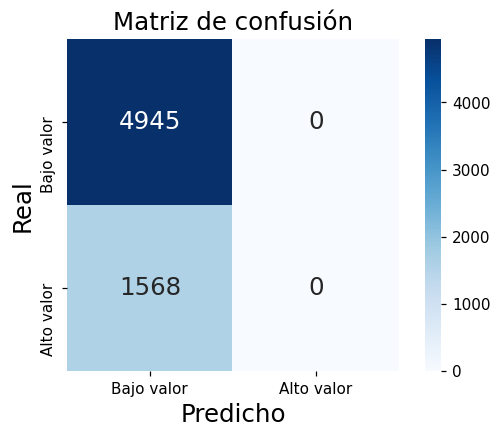

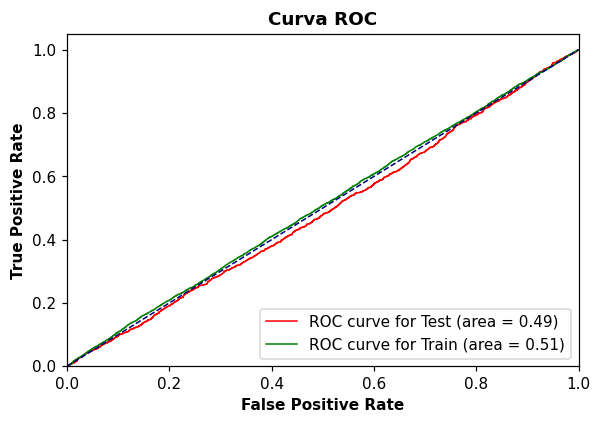

In [35]:
X_df_new = pd.DataFrame(np.vstack((X_test_assemble, X_train_assemble)))
X_train, X_test, y_train, y_test = train_test_split(X_df_new, y_df, test_size=0.20, random_state=0, stratify=y_df)

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Es decir, nos dió peor que un modelo RANDOM.

## Primer Preprocesamiento directo

Para esto, entonces hagamos un split con 'train_test_split' tal como veniamos haciendo en cada calculo de probabilidad de clase realizado con los distintos modelos. Mantenemos el mismo random_state pero solamente usaremos el *y_test* e *y_train* que nos dará el split, pues el *X_train* como *X_test* seran el del ensamble. 

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    1.0s finished


AUC-ROC score sobre test:  0.8716055178390870
AUC-ROC score sobre train:  0.8723348535039600
Accuracy sobre test:  0.7967142637801320
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}
              precision    recall  f1-score   support

  Bajo valor       0.81      0.91      0.86      4407
  Alto valor       0.75      0.56      0.64      2106

    accuracy                           0.80      6513
   macro avg       0.78      0.73      0.75      6513
weighted avg       0.79      0.80      0.79      6513



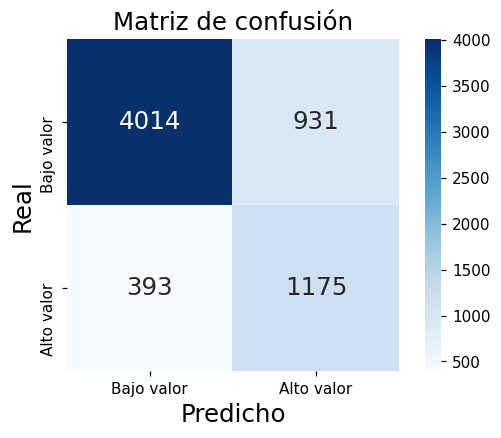

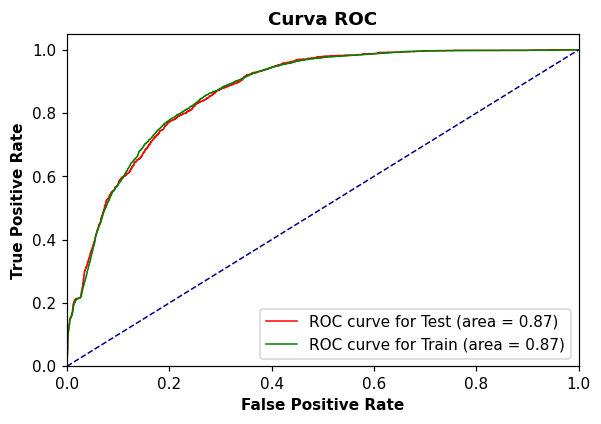

In [36]:
X_train_s, X_test_s, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train, X_test = X_train_assemble, X_test_assemble

params = {
        'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07],
}

clf = GaussianNB()
cv = StratifiedKFold(n_splits=20).split(X_train, y_train)
clf = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs = -1, verbose=4)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Lo cual se puede observar una mejora increible con un ensamble en comparacion a haber trabajo individualmente cada modelo.

## Segundo Preprocesamiento: get_dataframe_polynomial_all()

Para este caso, buscaremos realizar una expansión del dataset mediante PolynomialFeatures. Ésto solo se aplicará para TODAS las features de nuestro dataset. En este caso al trabajar con un ensamble haremos uso de la funcion del preprocessing.py que aplica PolynomialFeature a todas las features.



In [37]:
from preprocessing import get_dataframe_polynomial_all

* **Grado 2, True**: veamos primero con una expasión de grado 2 con interaction_only=True para las potencias:

In [38]:
X_train_ensamble, X_test_ensamble = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)               
X_train = get_dataframe_polynomial_all(X_train_ensamble, 2, True)
X_test = get_dataframe_polynomial_all(X_test_ensamble, 2, True)

params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
 AUC-ROC score sobre test:  0.8778927255937765
AUC-ROC score sobre train:  0.8797062682904661
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}


* **Grado 2, False**: lo mismo con intercation_only = False

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)               
X_train = get_dataframe_polynomial_all(X_train_ensamble, 2, False)
X_test = get_dataframe_polynomial_all(X_test_ensamble, 2, False)

params = {'var_smoothing': [1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07]}
cv_e = StratifiedKFold(n_splits=10).split(X_train, y_train)
clf = GridSearchCV(GaussianNB(), params, scoring='roc_auc', cv=cv_e, n_jobs = -1)
        
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Los mejores hiperpametros elegidos: ", clf.best_params_)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 27 features...
 AUC-ROC score sobre test:  0.8759083979901364
AUC-ROC score sobre train:  0.8771769969949272
Los mejores hiperpametros elegidos:  {'var_smoothing': 1e-13}


## Eligiendo al mejor: get_dataframe_polynomial_all()

Entonces como mejor preprocesamiento realizado al ensamble gaussiano es aquel donde expandimos con PolynomialFeatures con grado 2 e intercation_only=True para las potencias con un 'var_smoothing' de 1e-13.

Presentaremos este como mejor modelo para el ensamble. Entrenemos dicho modelo:

In [41]:
X_train_s, X_test, y_train_s, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=10, stratify=y_df)        
X_train, X_test = pd.DataFrame(X_train_assemble), pd.DataFrame(X_test_assemble)
X_train = get_dataframe_polynomial_all(X_train, 2, True)
X_test = get_dataframe_polynomial_all(X_test, 2, True)

clf = GaussianNB(var_smoothing = 1e-13)

clf.fit(X_train, y_train)

Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...
Dataset inicial con 6 features...
Dataset nuevo con PolynomialFeature con 21 features...


GaussianNB(var_smoothing=1e-13)

Veamos diferentes métricas para el mismo al predecir

 AUC-ROC score sobre test:  0.8778927255937765
AUC-ROC score sobre train:  0.8797062682904661
Accuracy sobre test:  0.7766006448641180
              precision    recall  f1-score   support

  Bajo valor       0.77      0.93      0.84      4102
  Alto valor       0.80      0.52      0.63      2411

    accuracy                           0.78      6513
   macro avg       0.79      0.72      0.74      6513
weighted avg       0.78      0.78      0.76      6513



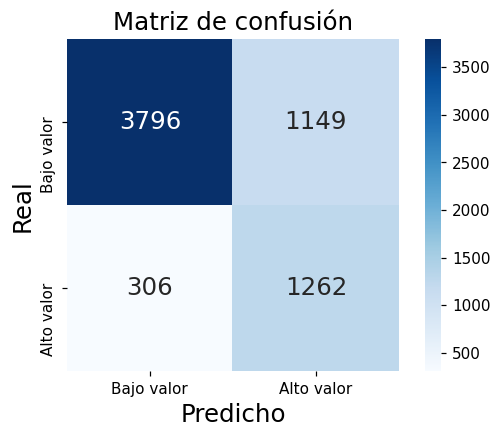

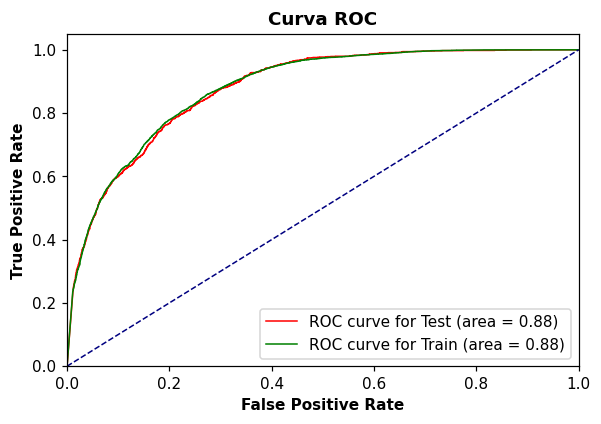

In [42]:
y_pred = clf.predict(X_test)


print(" AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf, X_test, y_test, X_train, y_train)


Un buen ensamble si miramos la diagonal, no es perfecto pues tiene un accuracy de 0.77 pero esto por tratar de optimizar el AUC-ROC al maximo que resultó 0.88 sobre Test.

# Predicciones holdout

Presentar los 2 modelos: 
    
* Ensamble Gaussiano
* Alguno de estas 3 elegir: CategorialNB, MultinomialNB ó GaussianNB